In [28]:
import numpy as np
from PIL import Image
import pandas as pd

# Voetbalcompetitie met Monte Carlo

Dit zijn de meegeleverde kansen.

Uitleg ("how to read"): De drie getallen in een veld geven de win-/gelijkspel-/verlieskans aan voor de thuisspelende partij (voor de uitspelende partij is winst en verlies natuurlijk omgedraaid). Bijv. voor de wedstrijd Ajax - PSV, zoek de rij van Ajax in de linkerkolom (thuisspelende partij) en daarbij de juiste kolom met PSV als uitspelend: 54/21/25. Deze waarden betekenen op een volgende dat: de thuisspelende partij (Ajax dus) met 54% kans gaat winnen, met 21% kans gelijk speelt of met 25% kans verliest van de uitspelende partij (PSV dus).

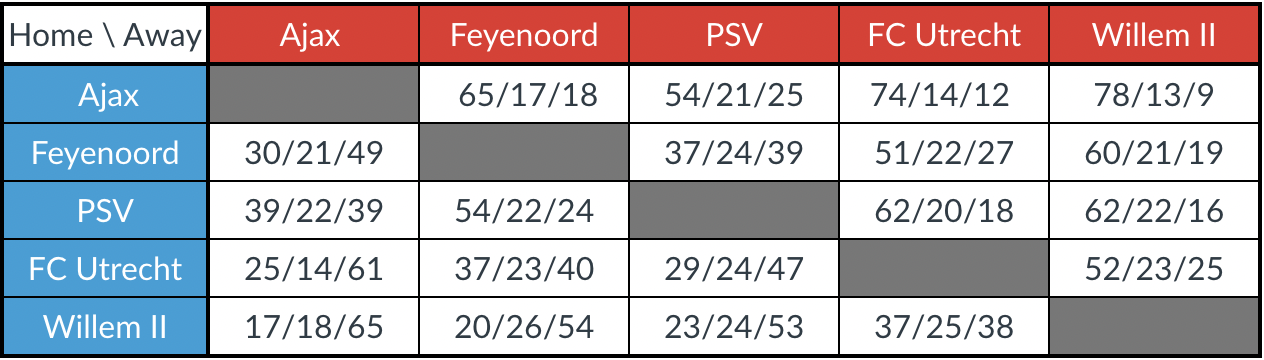

In [20]:
display(Image.open('images/Screenshot 2021-12-17 at 10.31.43.png'))

In [21]:
def draw_randomness(rng, normalizer = 1):
    img = Image.new('1', (200, 200))
    pixels = img.load()
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            random_number = rng.next() / normalizer # TODO: replace with RNG call
            pixels[x, y] = 0 if random_number < 0.5 else 1
    return img

## De opdracht

Eerst worden er een aantal RNG's gemaakt vervolgens zal de simulatie gemaakt worden.

### RNG
Er zullen een aantal RNG's aangeleverd worden met ieder z'n voor en nadelen.

#### Middle square

In [22]:
def select_middle(number, positions):
    left = True
    while len(str(number)) > positions:
        if left:
            number = int(str(number)[1:])
            left = False
        else:
            number = int(str(number)[:-1])
            left = True
    return number


class MidSquareGen:
    def __init__(self, seed):
        self.seed = seed

    def reset(self, seed):
        self.seed = seed

    def next(self):
        self.seed = select_middle(self.seed**2, 4)
        return self.seed / 10000.0

In [23]:
middle_square = MidSquareGen(12345)

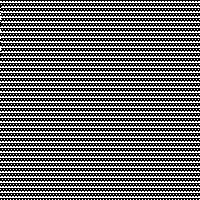

In [24]:
display(draw_randomness(middle_square))

#### LCG

In [25]:
class LCG:
    def __init__(self, seed, a, b, m):
        self.seed = seed
        self.a = a
        self.b = b
        self.m = m

    def change_seed(self, seed):
        self.seed = seed

    def next(self):
        self.seed = (self.a * self.seed + self.b) % self.m
        return self.seed

In [26]:
lcg = LCG(1, 4321, 1234, 2**8)

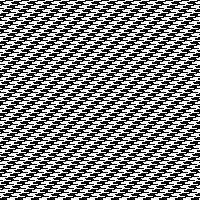

In [27]:
display(draw_randomness(lcg, 2**8))

### Monte Carlo Simulatie
Als eerst ga ik een loop maken die voor iedere wedstrijd uitspeeld en een ranking geeft

In [34]:
odds = pd.read_csv('odds.csv', names = ['Ajax', 'Feyenoord', 'PSV', 'FC Utrecht', 'Willem II'])
odds

,Ajax,Feyenoord,PSV,FC Utrecht,Willem II
Ajax,/,65/17/18,54/21/25,74/14/12,78/13/9
Feyenoord,30/21/49,/,37/24/39,51/22/27,60/21/19
PSV,39/22/39,54/22/24,/,62/20/18,62/22/16
FC Utrecht,25/14/61,37/23/40,29/24/47,/,52/23/25
Willem II,17/18/65,20/26/54,23/24/53,37/25/38,/
